# Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [ ]:
# Read the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

In [ ]:
# Select only the needed columns
df = df[['Unnamed: 0', 'post_text', 'label']]

In [ ]:
df["sentiment label"] = df["label"].map({ 0 : 2, 1 : 0})

In [ ]:
# df["label"] = df["label"].map({ 0 : 'non-depressed', 1 : 'depressed'})

# Data Pre-proccessing

In [ ]:
import nltk
import re #regular expression to clean data
from nltk.corpus import stopwords #stop word
nltk.download('stopwords') #corpus for stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

lemmatization

In [ ]:
import re #regular expression to clean data
from nltk.corpus import stopwords #stop word
nltk.download('stopwords') #corpus for stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import spacy

# Load the English model with spaCy's POS tagging from spaCy
modelspacy = spacy.load("en_core_web_sm")#load once

# Function to lemmatize text with spaCy
def lemmatize_text(text):
    # Process the text using spaCy, create Doc object
    docForLemmatization = modelspacy(text) #it includes tokenization and POS tagging

    # Lemmatize tokens, use "lemma_" attribute to get the lemma of each token
    lemmatized_tokens = [token.lemma_ for token in docForLemmatization]
    # and join them back into a single string
    return " ".join(lemmatized_tokens)

In [ ]:
def text_cleaning(text):

    text = text.lower() # Convert to lowercase

    text = re.sub(r'@[\S]+', '', text) # Remove usernames "sub" replacing substrings

    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove hyperlinks

    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove punctuation


    stop_words = set(stopwords.words('english')) # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = lemmatize_text(text)# Lemmatize text

    return text

# use text cleaning function to create 'clean_text' column
df['clean_text'] = df['post_text'].apply(text_cleaning)

In [ ]:
df.tail()

,Unnamed: 0,post_text,label,sentiment label,clean_text
19995,19995,A day without sunshine is like night.,0,2,day without sunshine like night
19996,19996,"Boren's Laws: (1) When in charge, ponder. (2) ...",0,2,boren law 1 charge ponder 2 trouble delegate 3...
19997,19997,The flow chart is a most thoroughly oversold p...,0,2,flow chart thoroughly oversell piece program d...
19998,19998,"Ships are safe in harbor, but they were never ...",0,2,ship safe harbor never mean stay
19999,19999,Black holes are where God is dividing by zero.,0,2,black hole god divide zero


# Fine-tuning RoBERTa

In [ ]:
# library creates object for the dataset
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import Dataset # to create structured dataset from a CSV file
from datasets import DatasetDict # to create a dictionary to store training and testing dataset
from datasets import load_dataset # to load the datasets

In [ ]:
# Extracting the important features only
final_df = df[['clean_text', 'sentiment label']]

# Renaming the features so they're compatible with the HuggingFace Trainer
final_df.rename(columns={'clean_text': 'text', 'sentiment label': 'labels'}, inplace=True)

<ipython-input-15-50e62c569ca0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'clean_text': 'text', 'sentiment label': 'labels'}, inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
# Splitting the data
train_data, test_data = train_test_split(final_df, test_size=0.2, shuffle=True, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)

# reset the index to start from 0 to n
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Update the dataset structure to include the splits
# Create datasetDict object, Each dataset is converted from a Pandas DataFrame
# to a HuggingFace Dataset object using the 'from_pandas' method
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'validation': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
#reduce time
!pip install accelerate>=0.21.0

In [ ]:
import torch
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score  #evaluation metrics

In [ ]:
#Pretrained model by huggingface
MODEL = "cardiffnlp/twitter-roberta-base-sentiment" #PretrainedModel
tokenizer = AutoTokenizer.from_pretrained(MODEL)  #tokenizer convert text to numerical tokens
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to tokenize the textual data before passing it to the model
def tokenize(examples):
  #the tokens get truncated if it exceeds 512 length
  return tokenizer(examples['text'], truncation=True, max_length=512) # Padding or return_tensors="pt" (Optional)
dataset = dataset.map(tokenize, batched=True)

# The hyperparameters we want to pass to the model
training_args = TrainingArguments(
    output_dir='./results', # the trained model is going to be saved in a directory names "results"
    learning_rate= 2e-5, # 2e-5=0.00002, learning rate controls the size of the step the improving takes
    num_train_epochs=10, #the model is trained on the training set 10 times
    per_device_train_batch_size=8, #for parallel processing, sets are divided into batches and each batch has 8 sample
    per_device_eval_batch_size=8,
    warmup_steps=500, # use the first 500 batch to warm up
    weight_decay=0.01, # to avoid overfitting
    logging_dir='./logs', #directory to save the logs
    logging_steps=1000,  # Log every 1000 steps
    evaluation_strategy="steps",  # Evaluate every logging_steps
    eval_steps=1000,  # Evaluate every 1000 steps
)

# The function that calulates the performance measures, in this case we used accuracy and f1 score
def compute_metrics(pred):
    labels = pred.label_ids # the true labels' ids from the dataset
    preds = pred.predictions.argmax(-1) #get the class for the highest probability predicted

    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': accuracy}

# Combining all of the previous steps, data, model, hyperparameters, performance measures and tokenizer in order to start training

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Train
trainer.train()

Step,Training Loss,Validation Loss,F1,Accuracy
1000,0.555400,0.499661,0.736466,0.738000
2000,0.488000,0.561213,0.718575,0.727000
3000,0.404700,0.488807,0.764702,0.766000
4000,0.383100,0.493557,0.782232,0.782500
5000,0.298500,0.797413,0.769547,0.771500
6000,0.316000,0.745442,0.792722,0.793000
7000,0.217100,1.085194,0.787150,0.788000
8000,0.241400,1.016854,0.791069,0.791500
9000,0.149900,1.197312,0.794520,0.794500
10000,0.162600,1.240824,0.793353,0.793500


TrainOutput(global_step=20000, training_loss=0.1941723816871643, metrics={'train_runtime': 2389.0754, 'train_samples_per_second': 66.972, 'train_steps_per_second': 8.371, 'total_flos': 1539316272387600.0, 'train_loss': 0.1941723816871643, 'epoch': 10.0})

## Applying on The dataset

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#Pretrained model by roberta fine-tuning
tokenizer = AutoTokenizer.from_pretrained('/content/results/checkpoint-16000')
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-16000')

In [ ]:
def polarity_scores_roberta(example):
    encoded_text= tokenizer(example,return_tensors="pt") #Convert text into 0,1 so model can understand
    output = model(**encoded_text) #Going to run encoded values
    scores = output[0][0].detach().numpy() #Converting tensor to numpy
    scores = softmax(scores) #Normalizes the results
    #Create a new dictionary to store the results
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['clean_text']
        myid = row['Unnamed: 0']
        res[myid] = polarity_scores_roberta(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
robertas = pd.DataFrame(res).T
robertas = robertas.reset_index().rename(columns={'index': 'Unnamed: 0'})
robertas = robertas.merge(df, how='left')

In [ ]:
#Use lambda function to label tweets as positive, negative or neutral
robertas['Rob_Analysis'] = robertas.apply(lambda x:
                                          'Negative' if x['roberta_neg'] > x['roberta_pos']
                                                else ('Positive'),axis=1)

In [ ]:
robertas.head()

,Unnamed: 0,roberta_neg,roberta_neu,roberta_pos,post_text,label,sentiment label,clean_text,Rob_Analysis
0,0,0.999979,5.082379e-06,0.000015,It's just over 2 years since I was diagnosed w...,1,0,2 year since diagnose anxiety depression today...,Negative
1,1,0.999978,1.606402e-06,0.000020,"It's Sunday, I need a break, so I'm planning t...",1,0,sunday need break planning spend little time p...,Negative
2,2,0.999972,6.555195e-07,0.000027,Awake but tired. I need to sleep but my brain ...,1,0,awake tired need sleep brain idea,Negative
3,3,0.999962,5.462678e-07,0.000038,RT @SewHQ: #Retro bears make perfect gifts and...,1,0,rt retro bear make perfect gift great beginner...,Negative
4,4,0.999967,3.117485e-06,0.000029,It’s hard to say whether packing lists are mak...,1,0,hard say whether pack list make life easy rein...,Negative


## Results

In [ ]:
#percentage of positive tweets
positiveTweets= robertas[robertas.Rob_Analysis=='Positive']
positiveTweets= round((positiveTweets.shape[0]/robertas.shape[0])*100,1)
positiveTweets

49.5

In [ ]:
#percentage of Negative tweets
NegativeTweets= robertas[robertas.Rob_Analysis=='Negative']
NegativeTweets= round((NegativeTweets.shape[0]/robertas.shape[0])*100,1)
NegativeTweets

50.5

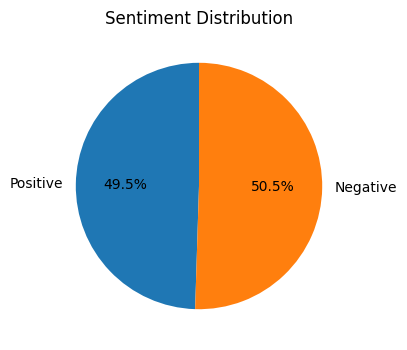

In [ ]:
# Sample data
labels = ['Positive', 'Negative']
sizes = [positiveTweets, NegativeTweets]  # These values should represent the percentages of each sentiment category

# Creating pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
robertas["label"] = robertas["label"].map({ 0 : 'Non-depressed', 1 : 'Depressed'})

<Axes: xlabel='label', ylabel='count'>

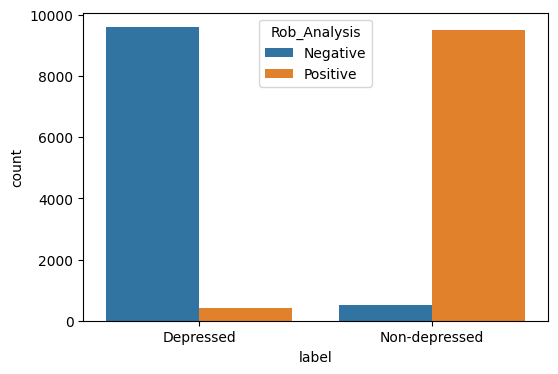

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(robertas, x="label", hue="Rob_Analysis", saturation = 1)